# Skin Cancer Classification using MobileNetv2 partially trained on ISIC 2019

## Data Preparation

This part is for ***INTERNAL USE*** only and should be ***RUN ONCE***.

Originally, the data are public from this [paper](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w42/Pacheco_On_Out-of-Distribution_Detection_Algorithms_With_Deep_Neural_Skin_Cancer_Classifiers_CVPRW_2020_paper.pdf), which can be downloaded via this [link](https://www.dropbox.com/s/nl3la5hhvfjn8hp/data.zip?dl=0) or delivered along with the project containing this notebook.
The data from the paper's authors are organized all in one folder (one for testing, validation, or training) with a CSV file containing all labels.
The target is to move all images belong to the same class into one folder for that class, for easier use with tensorflow & keras.

After the data are reorganized, in future work ***PLEASE REUSE*** that transformed data structure.

In [5]:
'''
Constants for handling data (e.g. paths)
'''

ORIGINAL_DATA = './data/skin_cancer'
ROOT = './data'

In [9]:
'''
Read the original labels.csv file
'''

import csv
LF_NAME = 'labels.csv'

lf = open(ORIGINAL_DATA + '/' + LF_NAME)
lf_reader = csv.reader(lf, delimiter = ',')
labels = {}
for row in list(lf_reader)[1:]: # skip the first row (column names)
    labels[row[0]] = row[1]
lf.close()

print('Number of obtained pairs of image-label: ', len(labels))
CLASSES = set(labels.values())
print(len(CLASSES), ' skin cancer classes: ', CLASSES)

Number of obtained pairs of image-label:  25331
8  skin cancer classes:  {'BCC', 'AK', 'NV', 'DF', 'MEL', 'BKL', 'SCC', 'VASC'}


In [10]:
'''
Regroup images, each class into one folder
RUN ONCE to prepare data structure only
In the future JUST REUSE the re-organized data
'''

import os, shutil

TEST_PATH = ROOT + '/test'
VAL_PATH = ROOT + '/val'
TRAIN_PATH = ROOT + '/train'

for f in [TEST_PATH, VAL_PATH, TRAIN_PATH]:
    for c in CLASSES:
        os.makedirs(f + '/' + c, exist_ok = True)
        
TEST_ORIGINAL_PATH = ORIGINAL_DATA + '/test/img' # 2533 images
VAL_ORIGINAL_PATH = ORIGINAL_DATA + '/val/img' # 2533 images
TRAIN_ORIGINAL_PATH = ORIGINAL_DATA + '/train/img' # 20265 images
# Total 25331 images

tmp = []
for f, o in [(TEST_PATH, TEST_ORIGINAL_PATH), (VAL_PATH, VAL_ORIGINAL_PATH), (TRAIN_PATH, TRAIN_ORIGINAL_PATH)]:
    s = 0
    for img in os.listdir(o):
        i = os.path.splitext(img)[0]
        c = labels[i]
        shutil.move(o + '/' + img, f + '/' + c)
        s += 1
    tmp.append(s)
    
N_TEST, N_VAL, N_TRAIN = tuple(tmp)
print('Number of moved images for test - val - train: ', N_TEST, N_VAL, N_TRAIN)

Number of moved images for test - val - train:  2533 2533 20265


## Building & training the model

In [11]:
'''
Libraries
FUTURE WORK SHOULD STARTS HERE!
'''

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Check for GPUs
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
'''
Load images into datasets
'''

DATA_PATH = './data'
TEST_PATH = DATA_PATH + '/test'
VAL_PATH = DATA_PATH + '/val'
TRAIN_PATH = DATA_PATH + '/train'

# Same as in paper
BATCH_SIZE = 40 
IMG_SIZE = (224, 224)

train_set = image_dataset_from_directory(TRAIN_PATH, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)
val_set = image_dataset_from_directory(VAL_PATH, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)
test_set = image_dataset_from_directory(TEST_PATH, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

Found 20265 files belonging to 8 classes.
Found 2533 files belonging to 8 classes.
Found 2533 files belonging to 8 classes.


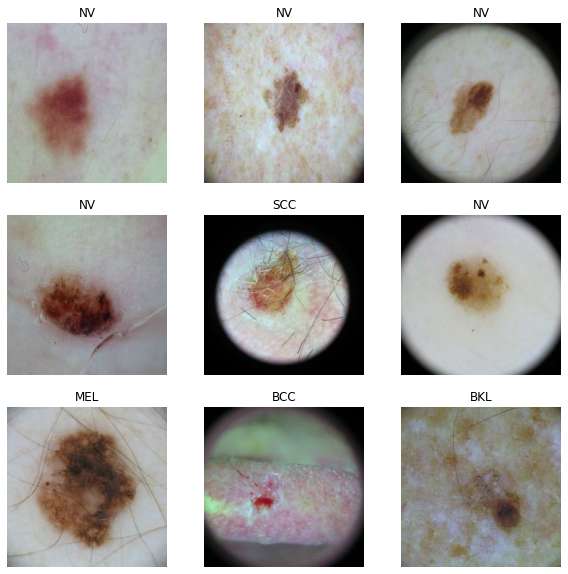

In [15]:
'''
Test images loaded
'''

CLASSES = train_set.class_names

# Show the first 9 images and labels in the training set
plt.figure(figsize = (10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(CLASSES[labels[i]])
        plt.axis('off')

In [17]:
'''
Use buffered prefetching to improve image loading performance
''' 

AUTOTUNE = tf.data.experimental.AUTOTUNE # for tf 2.3-; for tf 2.4+ remove 'experimental'

train_set = train_set.prefetch(buffer_size = AUTOTUNE)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)

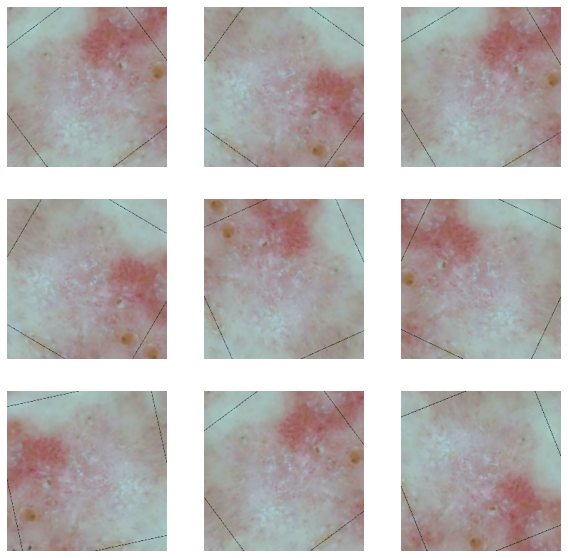

In [23]:
'''
Apply augmentation (rotation, flipping, changing contrast, ...) to training images
Expose the model to different aspects of the training data -> reduce overfitting
''' 

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
# more augmentation recommended if resource is abundant

# Test with an image to see the augmentations
for images, _ in train_set.take(1):
    plt.figure(figsize = (10, 10))
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [24]:
'''
Rescale the input to fit requirements of MobileNetv2
'''

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # just a function pointer to use later

In [56]:
'''
Download the MobileNetv2 model pretrained with ImageNet
Only use the convolution layers -> We will build the dense layers later for classification
'''

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')

print('Number of layers in the base model: ', len(base_model.layers))
base_model.summary()

Number of layers in the base model:  155
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________

In [31]:
'''
Test by feeding an image to the convolution layers
& see the final shape
'''

image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(40, 7, 7, 1280)


We will **not train the whole MobileNetv2 from scratch** as this model is already trained with ImageNet (1.4M images and 1000 classes).

We will **reuse the convolution layers from that pretrained model for feature extraction**, then **add some dense layers on top for classification task**.

With that manner, we is going to **train the dense layers**, obviously, **and some top (last, to the right) convolution layers** for improving accuracy. As the very first convolution layers only learn very generic and simple features which are universial accross all types of images, we only want to **tune the top-last convolution layers responsible for more specialized features**.

In [57]:
'''
Prepare the model
'''

# Freeze the bottom (first) convolution layers
# Only train some top (last) convolution layers + dense layers
base_model.trainable = True
for layer in base_model.layers[:100]: # Freeze all layers before the 100th layer
    layer.trainable = False

# Add a layer to flatten the feature shape after going through the convolution layers
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()

# Test with the example batch above
feature_batch_flattened = flatten_layer(feature_batch)
print(feature_batch_flattened.shape)

# Add 2 dense layers
dense_layer = tf.keras.layers.Dense(64, activation = 'relu') # if resource allows, try bigger number of neurals
output_layer = tf.keras.layers.Dense(len(CLASSES), activation = 'softmax') # 8 classes, use softmax for multi class

# Compile the model
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = flatten_layer(x)
DROPOUT_RATE = 0.2
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x) # to reduce overfitting
x = dense_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

# same learning rate, beta1 & beta2 (defaults) as in paper
# Sparse Categorical crossentropy loss is use for multi class - single label classification
# For multi class - multi label classification, use Categ. Crossentropy and label_mode='categorical' in image_dataset_from_directory
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

model.summary()

(40, 1280)
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_8 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_8 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1280) 

In [58]:
'''
Pretraining validation
'''

# initial loss & accuracy
loss0, accuracy0 = model.evaluate(val_set)

64/64 [==============================] - 11s 178ms/step - loss: 2.6541 - accuracy: 0.0482


In [59]:
'''
Initial training
'''

history = model.fit(train_set, epochs = 15, validation_data = val_set) # try more epochs if time allows

Epoch 1/15
507/507 [==============================] - 334s 658ms/step - loss: 1.1766 - accuracy: 0.5928 - val_loss: 1.0048 - val_accuracy: 0.6447
Epoch 2/15
507/507 [==============================] - 170s 335ms/step - loss: 1.0019 - accuracy: 0.6486 - val_loss: 0.9168 - val_accuracy: 0.6751
Epoch 3/15
507/507 [==============================] - 171s 338ms/step - loss: 0.9333 - accuracy: 0.6719 - val_loss: 0.9436 - val_accuracy: 0.6605
Epoch 4/15
507/507 [==============================] - 171s 338ms/step - loss: 0.8819 - accuracy: 0.6878 - val_loss: 0.8826 - val_accuracy: 0.6869
Epoch 5/15
507/507 [==============================] - 171s 338ms/step - loss: 0.8442 - accuracy: 0.6972 - val_loss: 0.8133 - val_accuracy: 0.7138
Epoch 6/15
507/507 [==============================] - 171s 338ms/step - loss: 0.8230 - accuracy: 0.7096 - val_loss: 0.8109 - val_accuracy: 0.7138
Epoch 7/15
507/507 [==============================] - 171s 338ms/step - loss: 0.7913 - accuracy: 0.7195 - val_loss: 0.8419 -

In [60]:
'''
More training
'''

# Try smaller learning rate to see if val_accuracy improves
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

more_history = model.fit(train_set, epochs = 20, initial_epoch = history.epoch[-1], validation_data = val_set)
# the epochs number is the total epochs, we have trained 15 epoches so it will run 5 more

Epoch 15/20
507/507 [==============================] - 338s 666ms/step - loss: 0.5137 - accuracy: 0.8133 - val_loss: 0.7832 - val_accuracy: 0.7560
Epoch 16/20
507/507 [==============================] - 300s 591ms/step - loss: 0.4817 - accuracy: 0.8241 - val_loss: 0.7998 - val_accuracy: 0.7548
Epoch 17/20
507/507 [==============================] - 171s 337ms/step - loss: 0.4639 - accuracy: 0.8276 - val_loss: 0.8131 - val_accuracy: 0.7533
Epoch 18/20
507/507 [==============================] - 171s 338ms/step - loss: 0.4561 - accuracy: 0.8288 - val_loss: 0.8136 - val_accuracy: 0.7560
Epoch 19/20
507/507 [==============================] - 171s 338ms/step - loss: 0.4465 - accuracy: 0.8348 - val_loss: 0.8112 - val_accuracy: 0.7544
Epoch 20/20
507/507 [==============================] - 234s 462ms/step - loss: 0.4401 - accuracy: 0.8385 - val_loss: 0.8022 - val_accuracy: 0.7576


In [62]:
'''
And more training
'''

# It seems that smaller learning rate works, let's do 5 more epochs
even_more_history = model.fit(train_set, epochs = 25, initial_epoch = more_history.epoch[-1], validation_data = val_set)

Epoch 20/25
507/507 [==============================] - 324s 639ms/step - loss: 0.4297 - accuracy: 0.8391 - val_loss: 0.8392 - val_accuracy: 0.7529
Epoch 21/25
507/507 [==============================] - 171s 337ms/step - loss: 0.4227 - accuracy: 0.8412 - val_loss: 0.8443 - val_accuracy: 0.7521
Epoch 22/25
507/507 [==============================] - 294s 580ms/step - loss: 0.4180 - accuracy: 0.8450 - val_loss: 0.8223 - val_accuracy: 0.7592
Epoch 23/25
507/507 [==============================] - 259s 510ms/step - loss: 0.4064 - accuracy: 0.8465 - val_loss: 0.8555 - val_accuracy: 0.7540
Epoch 24/25
507/507 [==============================] - 345s 680ms/step - loss: 0.4000 - accuracy: 0.8518 - val_loss: 0.8778 - val_accuracy: 0.7481
Epoch 25/25
507/507 [==============================] - 172s 339ms/step - loss: 0.3885 - accuracy: 0.8558 - val_loss: 0.8607 - val_accuracy: 0.7540


In [68]:
'''
And even, more training, phew :'(
'''

# let's do 15 more epochs
final_history = model.fit(train_set, epochs = 40, initial_epoch = even_more_history.epoch[-1], validation_data = val_set)

Epoch 25/40
507/507 [==============================] - 281s 555ms/step - loss: 0.3883 - accuracy: 0.8562 - val_loss: 0.8549 - val_accuracy: 0.7608
Epoch 26/40
507/507 [==============================] - 171s 338ms/step - loss: 0.3820 - accuracy: 0.8591 - val_loss: 0.8800 - val_accuracy: 0.7615
Epoch 27/40
507/507 [==============================] - 221s 436ms/step - loss: 0.3762 - accuracy: 0.8588 - val_loss: 0.8726 - val_accuracy: 0.7631
Epoch 28/40
507/507 [==============================] - 249s 491ms/step - loss: 0.3685 - accuracy: 0.8622 - val_loss: 0.8762 - val_accuracy: 0.7600
Epoch 29/40
507/507 [==============================] - 171s 338ms/step - loss: 0.3651 - accuracy: 0.8640 - val_loss: 0.8890 - val_accuracy: 0.7631
Epoch 30/40
507/507 [==============================] - 171s 336ms/step - loss: 0.3603 - accuracy: 0.8647 - val_loss: 0.9037 - val_accuracy: 0.7568
Epoch 31/40
507/507 [==============================] - 170s 336ms/step - loss: 0.3599 - accuracy: 0.8647 - val_loss: 0

Total epochs:  43


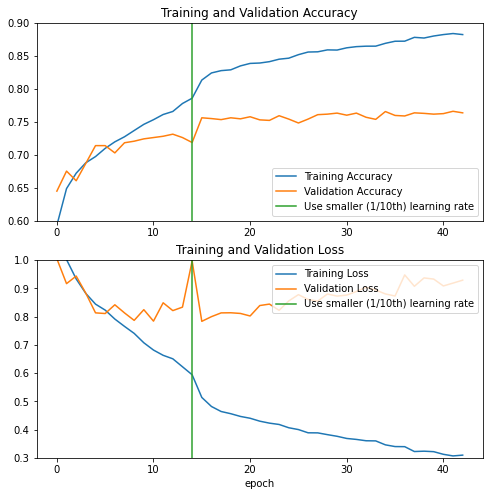

In [72]:
'''
Visualize the traininng results
'''

histories = [history, more_history, even_more_history, final_history]
acc, val_acc, loss, val_loss = [], [], [], []
for h in histories:
    acc += h.history['accuracy']
    val_acc += h.history['val_accuracy']
    loss += h.history['loss']
    val_loss += h.history['val_loss']
    
print('Total epochs: ', len(acc)) 
# The training code contains a bit mistake as we retrain the first epoch from previous history every time
# -> 3 more epochs

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0.6, 0.9])
plt.plot([14, 14], plt.ylim(), label = 'Use smaller (1/10th) learning rate')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([0.3, 1.0])
plt.plot([14, 14], plt.ylim(), label = 'Use smaller (1/10th) learning rate')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

**NOTICE:** we really need more training epochs as our graph is too ugly, the accuracy is not high and stable and the loss is not converging well.

=> We encounter ***OVERFITTING***

However, we are able to score > 0.75 accuracy, where the MobileNetv2 model trained in the paper scores 0.812 on average. So we think this is acceptable.

## Testing the trained model

In [73]:
'''
Test with the testing dataset
'''

test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy :', test_acc)

64/64 [==============================] - 33s 514ms/step - loss: 0.8693 - accuracy: 0.7769
Test accuracy : 0.7769443392753601


In [74]:
'''
Save the model for future use
'''

MODEL_PATH = './model'
os.makedirs(MODEL_PATH, exist_ok = True)
model.save(MODEL_PATH)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models\assets


In [83]:
'''
Save the class names for later use
'''

with open('classes.txt', 'w') as f:
    for c in CLASSES:
        f.write(c + ' ')

Predictions:
 [2 5 2 2 4 4 5 5 2 5 5 5 4 5 5 5 6 5 1 1 5 6 5 5 5 2 5 3 4 5 4 5 5 5 5 4 4
 5 5 5]
Labels:
 [2 5 6 2 4 4 5 5 1 5 5 5 4 5 5 4 1 5 1 1 1 2 5 5 5 2 5 3 4 5 4 4 1 5 5 4 4
 5 5 1]


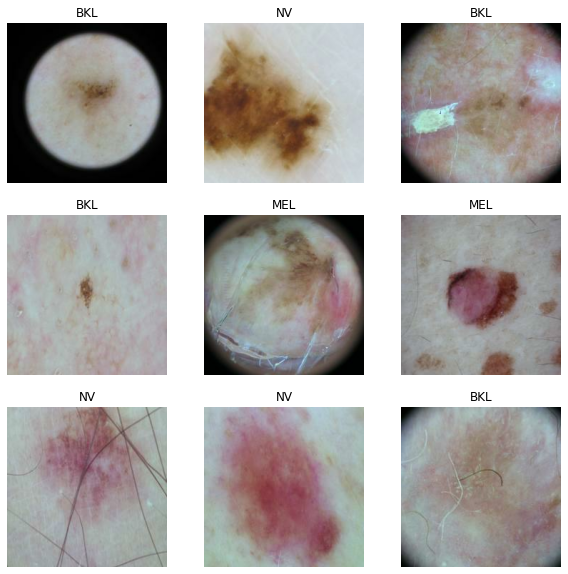

In [79]:
'''
See some visualization in testing
'''

# Retrieve some images from the test set
test_images, test_labels = test_set.as_numpy_iterator().next()

predictions = model.predict_on_batch(test_images)
predictions = np.argmax(predictions, axis = 1) # select the highest probability -> predicted class

print('Predictions:\n', predictions)
print('Labels:\n', test_labels)

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].astype("uint8"))
    plt.title(CLASSES[predictions[i]])
    plt.axis('off')

In [86]:
'''
Reload the model for demo
'''

import tensorflow as tf

MODEL_PATH = './model'

CLASSES = None
with open('classes.txt', 'r') as f:
    CLASSES = f.readline().split()
    
model = tf.keras.models.load_model(MODEL_PATH)

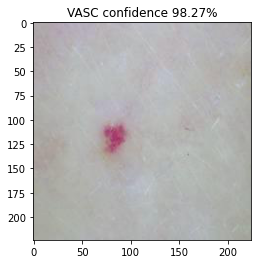

In [102]:
'''
Demo with one image
'''

import numpy as np

IMAGE_PATH = './one_image_test_VASC.jpeg'
IMAGE_SIZE = (224, 224)

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size = IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)

plt.title(CLASSES[np.argmax(prediction)] + ' confidence ' + '{:.2f}'.format(100 * np.max(prediction)) + '%')
plt.imshow(img)

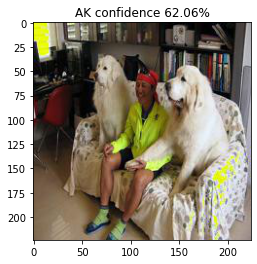

In [104]:
'''
Test an out-of-distribution (OOD) image
'''

IMAGE_PATH = './one_image_test_OOD_Dog_Human.jpeg'
IMAGE_SIZE = (224, 224)

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size = IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)

plt.title(CLASSES[np.argmax(prediction)] + ' confidence ' + '{:.2f}'.format(100 * np.max(prediction)) + '%')
plt.imshow(img)

## References
* Paper: [On Out-of-Distribution Detection Algorithms with Deep Neural Skin Cancer
Classifiers](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w42/Pacheco_On_Out-of-Distribution_Detection_Algorithms_With_Deep_Neural_Skin_Cancer_Classifiers_CVPRW_2020_paper.pdf)
* Tensorflow docs:
    * [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)
    * [Docs Home](https://www.tensorflow.org/api_docs/python/tf)